/home/gperaltag/mi_entorno/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


No se encontró un checkpoint. Iniciando desde la época 0.
Iniciando época 1


Epoch 1:   0%|          | 1/5469 [00:08<13:05:06,  8.61s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 1:  37%|███▋      | 2001/5469 [58:38<4:03:23,  4.21s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 1:  73%|███████▎  | 4001/5469 [1:57:04<1:42:31,  4.19s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 1: 100%|██████████| 5469/5469 [2:39:51<00:00,  1.75s/it]  


Época 1 - Pérdida Entrenamiento: 0.3511, Pérdida Validación: 0.3080, Precisión Validación: 85.87%
Mejor modelo guardado en best_film_model.pth
Nuevo mejor modelo guardado con precisión: 85.87%
Iniciando época 2


Epoch 2:   0%|          | 1/5469 [00:15<22:56:33, 15.10s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 2:  37%|███▋      | 2001/5469 [58:33<3:38:36,  3.78s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 2:  73%|███████▎  | 4001/5469 [1:56:47<1:23:02,  3.39s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 2: 100%|██████████| 5469/5469 [2:39:29<00:00,  1.75s/it]  


Época 2 - Pérdida Entrenamiento: 0.3039, Pérdida Validación: 0.3010, Precisión Validación: 86.27%
Mejor modelo guardado en best_film_model.pth
Nuevo mejor modelo guardado con precisión: 86.27%
Iniciando época 3


Epoch 3:   0%|          | 1/5469 [00:15<23:43:55, 15.62s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 3:  37%|███▋      | 2001/5469 [58:30<3:53:56,  4.05s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 3:  73%|███████▎  | 4001/5469 [1:56:45<1:42:10,  4.18s/it]

Checkpoint guardado en batch_checkpoint.pth


Epoch 3: 100%|██████████| 5469/5469 [2:39:26<00:00,  1.75s/it]  


Época 3 - Pérdida Entrenamiento: 0.3008, Pérdida Validación: 0.2989, Precisión Validación: 86.35%
Mejor modelo guardado en best_film_model.pth
Nuevo mejor modelo guardado con precisión: 86.35%


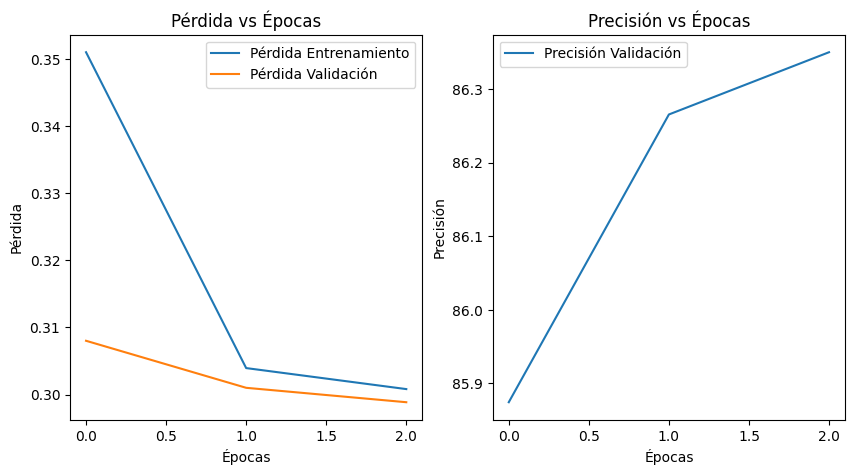

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

torch.backends.cudnn.enabled = False  # Evitar problemas con GRU

# ------------------- Checkpoint Functions -------------------

def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)
    print(f"Checkpoint guardado en {filename}")

def save_best_model(model, filename='best_film_model.pth'):
    """Guarda el mejor modelo."""
    torch.save(model.state_dict(), filename)
    print(f"Mejor modelo guardado en {filename}")

def load_checkpoint(filename='checkpoint.pth', model=None, optimizer=None):
    if os.path.isfile(filename):
        print(f"Cargando checkpoint desde {filename}...")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        batch_idx = checkpoint.get('batch_idx', 0)
        best_accuracy = checkpoint['best_accuracy']
        print(f"Reanudando desde la época {start_epoch}, batch {batch_idx}, con precisión {best_accuracy:.2f}%")
        return model, optimizer, start_epoch, batch_idx, best_accuracy
    else:
        print("No se encontró un checkpoint. Iniciando desde la época 0.")
        return model, optimizer, 0, 0, 0.0

# ------------------- Modelo y Dataset -------------------

class FiLMResBlock(nn.Module):
    def __init__(self, in_channels):
        super(FiLMResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, gamma, beta):
        out = self.conv1(x)
        out = self.conv2(self.relu(out))
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta
        return self.relu(out)

class FiLMNetwork(nn.Module):
    def __init__(self, num_classes, max_length, use_resnet=True):
        super(FiLMNetwork, self).__init__()
        if use_resnet:
            resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(
                resnet.conv1, 
                resnet.bn1, 
                resnet.relu, 
                resnet.maxpool, 
                resnet.layer1,  
                resnet.layer2,  
                resnet.layer3   
            )
        else:
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            )
        
        self.reduce_channels = nn.Conv2d(1026, 128, kernel_size=1)
        self.resblocks = nn.ModuleList([FiLMResBlock(128) for _ in range(4)])
        self.word_embedding = nn.Embedding(256, 200)
        self.gru = nn.GRU(input_size=200, hidden_size=4096, batch_first=True)
        self.affine_gamma = nn.Linear(4096, 128)
        self.affine_beta = nn.Linear(4096, 128)
        self.classifier = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def add_coordinates(self, features):
        batch_size, _, height, width = features.size()
        x_coords = torch.linspace(-1, 1, steps=width).repeat(batch_size, height, 1).unsqueeze(1)
        y_coords = torch.linspace(-1, 1, steps=height).repeat(batch_size, width, 1).unsqueeze(1).transpose(2, 3)
        coords = torch.cat([x_coords, y_coords], dim=1).to(features.device)
        return torch.cat([features, coords], dim=1)

    def forward(self, images, questions):
        features = self.feature_extractor(images)
        features = self.add_coordinates(features)
        features = self.reduce_channels(features)
        question_embedding = self.gru_forward(questions)
        gamma = self.affine_gamma(question_embedding)
        beta = self.affine_beta(question_embedding)
        for resblock in self.resblocks:
            features = resblock(features, gamma, beta)
        return self.classifier(features)

    def gru_forward(self, questions):
        embedded = self.word_embedding(questions)
        _, hidden = self.gru(embedded)
        return hidden.squeeze(0)

class CLEVRDataset(Dataset):
    def __init__(self, image_dir, question_file, max_length, transform=None):
        self.image_dir = image_dir
        with open(question_file, 'r') as f:
            self.questions = json.load(f)['questions']
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        image_path = os.path.join(self.image_dir, question['image_filename'])
        image = Image.open(image_path).convert('RGB')
        question_tensor = torch.tensor([ord(c) for c in question['question']], dtype=torch.long)
        question_tensor = torch.nn.functional.pad(question_tensor, (0, self.max_length - question_tensor.size(0)))
        label = int(question['answer']) if question['answer'].isdigit() else 0
        if self.transform:
            image = self.transform(image)
        return image, question_tensor, label

def collate_fn(batch):
    images, questions, labels = zip(*batch)
    images = torch.stack(images)
    questions = torch.stack(questions)
    labels = torch.tensor(labels)
    return images, questions, labels

# ------------------- Gráficos -------------------

def plot_loss_accuracy(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Pérdida Entrenamiento')
    plt.plot(val_losses, label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida vs Épocas')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Precisión Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión vs Épocas')

    plt.show()

# ------------------- Evaluación y Entrenamiento -------------------

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, questions, labels in dataloader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), 100 * correct / total

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs, start_epoch=0, best_accuracy=0.0):
    patience = 1
    epochs_no_improve = 0

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(start_epoch, epochs):
        print(f"Iniciando época {epoch + 1}")
        model.train()
        total_train_loss = 0

        for batch_idx, (images, questions, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}')):
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            if batch_idx % 2000 == 0:
                save_checkpoint({
                    'epoch': epoch,
                    'batch_idx': batch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_accuracy': best_accuracy
                }, filename='batch_checkpoint.pth')

        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Época {epoch + 1} - Pérdida Entrenamiento: {train_losses[-1]:.4f}, "
              f"Pérdida Validación: {val_loss:.4f}, Precisión Validación: {val_accuracy:.2f}%")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            epochs_no_improve = 0
            save_best_model(model)  # Guardando el mejor modelo.
            print(f"Nuevo mejor modelo guardado con precisión: {best_accuracy:.2f}%")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping en la época {epoch + 1}. No hubo mejora en {patience} épocas consecutivas.")
            break

    plot_loss_accuracy(train_losses, val_losses, val_accuracies)

# ------------------- Función Principal -------------------

def main():
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    with open('CLEVR_v1.0/questions/CLEVR_train_questions.json', 'r') as f:
        questions = json.load(f)['questions']
    max_length = max(len(q['question']) for q in questions)

    train_data = CLEVRDataset('CLEVR_v1.0/images/train', 'CLEVR_v1.0/questions/CLEVR_train_questions.json', max_length, transform)
    val_data = CLEVRDataset('CLEVR_v1.0/images/val', 'CLEVR_v1.0/questions/CLEVR_val_questions.json', max_length, transform)

    train_loader = DataLoader(train_data, batch_size=128, collate_fn=collate_fn, shuffle=True, num_workers=32)
    val_loader = DataLoader(val_data, batch_size=128, collate_fn=collate_fn, num_workers=32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FiLMNetwork(num_classes=28, max_length=max_length).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    model, optimizer, start_epoch, batch_idx, best_accuracy = load_checkpoint('batch_checkpoint.pth', model, optimizer)

    train(model, train_loader, val_loader, criterion, optimizer, device, epochs=3, start_epoch=start_epoch, best_accuracy=best_accuracy)

if __name__ == "__main__":
    main()
